In [1]:
from typing import List

import os
import json

import h5py
import numpy as np

# for getting all combinations of the highres choice
from itertools import combinations

# set a random number seed for reproducibility
np.random.seed(0)

In [2]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

In [3]:
# if you are in the root folder, don't run this line
os.chdir("..")
os.getcwd()

'/home/jibancat/Documents/PYTHON/lya_emulator_full'

In [4]:
# MF emulator related modules
from lyaemu.mf_trainset_optimize import TrainSetOptimize

# for normalize the input parameter to a unit cube
from lyaemu.latin_hypercube import map_to_unit_cube_list

def input_normalize(
    params: np.ndarray, param_limits: np.ndarray
) -> np.ndarray:
    """
    Map the parameters onto a unit cube so that all the variations are
    similar in magnitude.
    
    :param params: (n_points, n_dims) parameter vectors
    :param param_limits: (n_dim, 2) param_limits is a list 
        of parameter limits.
    :return: params_cube, (n_points, n_dims) parameter vectors 
        in a unit cube.
    """
    nparams = np.shape(params)[1]
    params_cube = map_to_unit_cube_list(params, param_limits)
    assert params_cube.shape[1] == nparams

    return params_cube

In [5]:
def plot_parameters(
    X_train: List[np.ndarray],
    parameter_names: List[str] = [
        r"$n_s$",
        r"$A_p$",
        r"$\mathrm{He}_{re_i}$",
        r"$\mathrm{He}_{re_f}$",
        r"$\alpha_q$",
        r"$h$",
        r"$\Omega_m$",
        r"$\mathrm{H}_\mathrm{reionz}$",
        r"$\mathrm{BH}_{feedback}$",
    ],
):
    """
    Plot the selected samples with all other samples in the input data.
    This would enable us to investigate locations of the selected training samples.
    """
    n_parameters = X_train[0].shape[1]

    for i in range(n_parameters):
        for j in range(i + 1, n_parameters):
            plt.scatter(
                X_train[0][:, i],
                X_train[0][:, j],
                marker="o",
                label="LowRes training data",
                color="C0",
                s=100,
            )
            plt.scatter(
                X_train[1][:, i],
                X_train[1][:, j],
                marker="o",
                label="HighRes training data",
                color="C1",
                s=40,
            )
            plt.legend()
            plt.xlabel(parameter_names[i])
            plt.ylabel(parameter_names[j])
            plt.show()

# Optimize the choice of high-res using low-fidelity only emulator

Low-fidelity only emulator -

    f ~ GP(X_train, Y_train)

    X_train = input parameters in a unit cube
    Y_train = log10(flux power spectra)

In [6]:
# read param file and the flux power spectra
with open("data/emulator_params.json", "r") as param:
    param = json.load(param)
    
f = h5py.File("data/cc_emulator_flux_vectors_tau1000000.hdf5", "r")

print("All keys", f.keys())

print("Shape of redshfits", f["zout"].shape)
print("Shape of params", f["params"].shape)
print("Shape of kfkms", f["kfkms"].shape)
print("Shape of kfmpc", f["kfmpc"].shape)
print("Shape of flux vectors", f["flux_vectors"].shape)

# use kfmpc so all redshifts use the same k bins
kfmpc = f["kfmpc"][()]

zout = f["zout"][()]

# flux power spectra, all redshifts
flux_vectors = f["flux_vectors"][()]

# read flux power spectrum at ith redshift
# flux power spectrum | z = ?
get_flux_vector_at_z = lambda i : flux_vectors[:, i * len(kfmpc) : (i + 1) * len(kfmpc)]

last_flux_vector = get_flux_vector_at_z(len(zout) - 1)
assert len(last_flux_vector) == f["params"].shape[0]
assert last_flux_vector.shape[1] == len(kfmpc)

first_flux_vector = get_flux_vector_at_z(0)
assert len(first_flux_vector) == f["params"].shape[0]
assert first_flux_vector.shape[1] == len(kfmpc)

All keys <KeysViewHDF5 ['flux_vectors', 'kfkms', 'kfmpc', 'params', 'zout']>
Shape of redshfits (18,)
Shape of params (30, 9)
Shape of kfkms (30, 18, 12)
Shape of kfmpc (12,)
Shape of flux vectors (30, 216)


In [7]:
%%capture
# runs for ~15 mins on my laptop if n_optimization_restarts=5

# select 2 samples out of 30 samples, use 28 samples to validate
# the GP loss
num_selected = 2
n_optimization_restarts = 10

# setup parameter settings
param_limits = np.array(param["param_limits"])
X_train = f["params"][()]

# No need to normalize since only single fidelity
# but it's better to map param to a unit cube to avoid
# ARD hyperparameter optimization searching in a wide
# dynamical range
X = input_normalize(X_train, param_limits=param_limits)
print("[Info] Input parameters are normalized to a unit cube.")

num_samples, _ = X.shape

# looking for all possible combinations
all_combinations = list(combinations(range(num_samples), num_selected))

all_z_loss = []

# loop over all redshifts
for i, z in enumerate(zout):

    # if not log scale, some selections cannot be trained, which might
    # indicate log scale is a better normalization for GP
    Y = np.log10(get_flux_vector_at_z(i))
    print("[Info] Getting flux vector at z = {:.3g} ...".format(z))
    print("[Info] Trun the flux power into log scale.")

    train_opt = TrainSetOptimize(X=X, Y=Y)

    # loop over to get the least loss 2 indices
    # It takes time to loop over all redhifts ...
    all_loss = []

    for j,selected_index in enumerate(all_combinations):

        # need to convert to boolean array
        ind = np.zeros(num_samples, dtype=np.bool)
        ind[np.array(selected_index)] = True

        loss = train_opt.loss(ind, n_optimization_restarts=n_optimization_restarts)

        print("iteration: {} out of {}".format((i, j), (len(zout), len(all_combinations))))

        all_loss.append(loss)
    
    all_z_loss.append(all_loss)

In [8]:
# find the set of 2 indices best minimize the loss

all_z_selected_index = []

# need to print for all redshifts
for i,z in enumerate(zout):

    all_loss = all_z_loss[i]

    selected_index = np.array(all_combinations[np.argmin(all_loss)])

    print("Optimal two ({:2d}, {:2d}) for z = {:.3g}".format(selected_index[0], selected_index[1], z))

    all_z_selected_index.append(selected_index)

Optimal two (14, 20) for z = 5.4
Optimal two ( 7, 27) for z = 5.2
Optimal two (13, 28) for z = 5
Optimal two (14, 15) for z = 4.8
Optimal two ( 3, 17) for z = 4.6
Optimal two (18, 28) for z = 4.4
Optimal two (13, 28) for z = 4.2
Optimal two (21, 29) for z = 4
Optimal two ( 8, 28) for z = 3.8
Optimal two (14, 20) for z = 3.6
Optimal two (14, 15) for z = 3.4
Optimal two (14, 28) for z = 3.2
Optimal two (10, 13) for z = 3
Optimal two ( 9, 22) for z = 2.8
Optimal two ( 1, 13) for z = 2.6
Optimal two (20, 23) for z = 2.4
Optimal two ( 0, 24) for z = 2.2
Optimal two ( 1, 16) for z = 2


In [9]:
%%capture
# runs ~ 2 mins on my laptop

# search for the 3rd index by conditioning on the optimal two

all_z_next_loss = []
all_z_next_selected_index = []

# loop over all redshifts
for i, selected_index in enumerate(all_z_selected_index):

    # turn integers into a boolean array
    prev_ind = np.zeros(num_samples, dtype=np.bool)
    prev_ind[np.array(selected_index)] = True

    assert np.sum(prev_ind) == len(selected_index)
    
    # this method loop over all index \in {1..30} - {prev_ind}
    # and compute the loss
    next_index, all_next_loss = train_opt.optimize(prev_ind, n_optimization_restarts=n_optimization_restarts)

    # optimal next selection indices
    optimal_index = np.append(selected_index, next_index)

    assert np.where(~prev_ind)[0][np.argmin(all_next_loss)] == next_index

    all_z_next_selected_index.append(optimal_index)
    all_z_next_loss.append(all_next_loss)

In [10]:
# print the set of 3 indices best minimize the loss

for i,z in enumerate(zout):

    selected_index = all_z_next_selected_index[i]

    print("Optimal three ({:2d}, {:2d}, {:2d}) for z = {:.3g}".format(selected_index[0], selected_index[1], selected_index[2], z))

Optimal three (14, 20, 17) for z = 5.4
Optimal three ( 7, 27, 28) for z = 5.2
Optimal three (13, 28, 29) for z = 5
Optimal three (14, 15,  8) for z = 4.8
Optimal three ( 3, 17, 10) for z = 4.6
Optimal three (18, 28, 21) for z = 4.4
Optimal three (13, 28, 21) for z = 4.2
Optimal three (21, 29, 24) for z = 4
Optimal three ( 8, 28,  5) for z = 3.8
Optimal three (14, 20, 17) for z = 3.6
Optimal three (14, 15, 13) for z = 3.4
Optimal three (14, 28, 21) for z = 3.2
Optimal three (10, 13, 24) for z = 3
Optimal three ( 9, 22, 23) for z = 2.8
Optimal three ( 1, 13, 22) for z = 2.6
Optimal three (20, 23, 10) for z = 2.4
Optimal three ( 0, 24, 11) for z = 2.2
Optimal three ( 1, 16, 17) for z = 2


z = 2


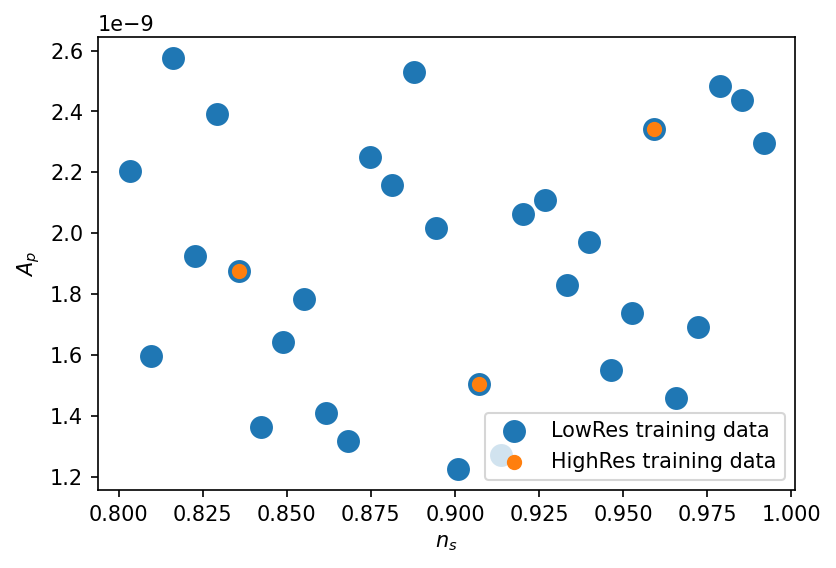

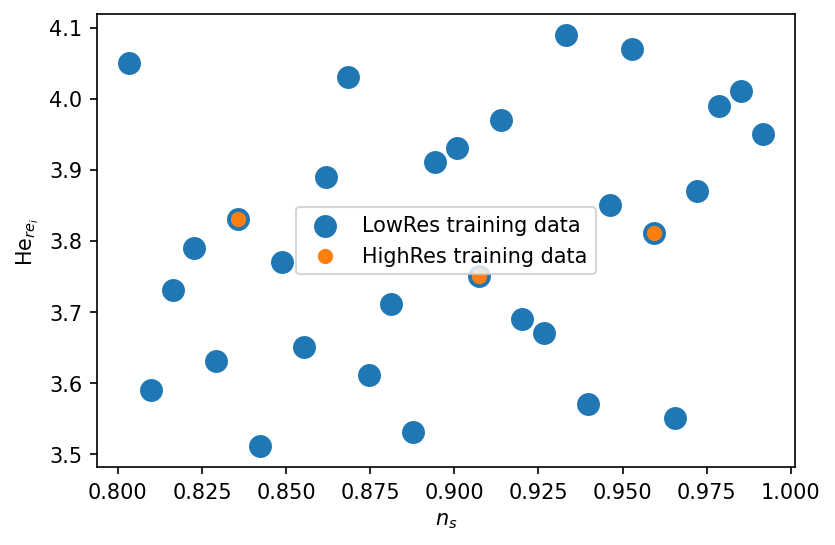

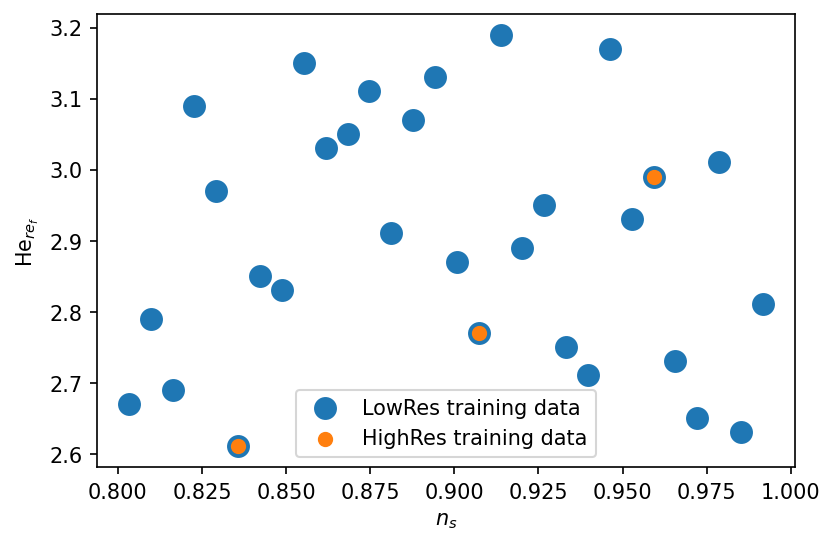

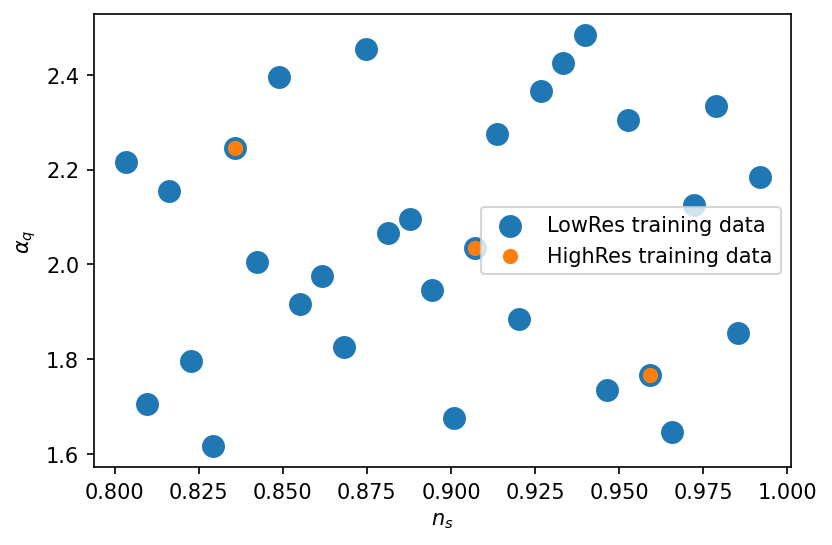

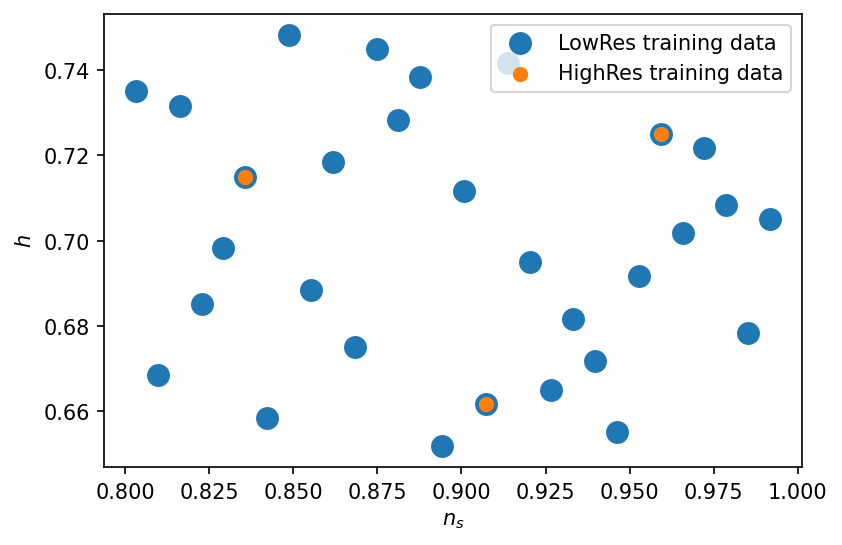

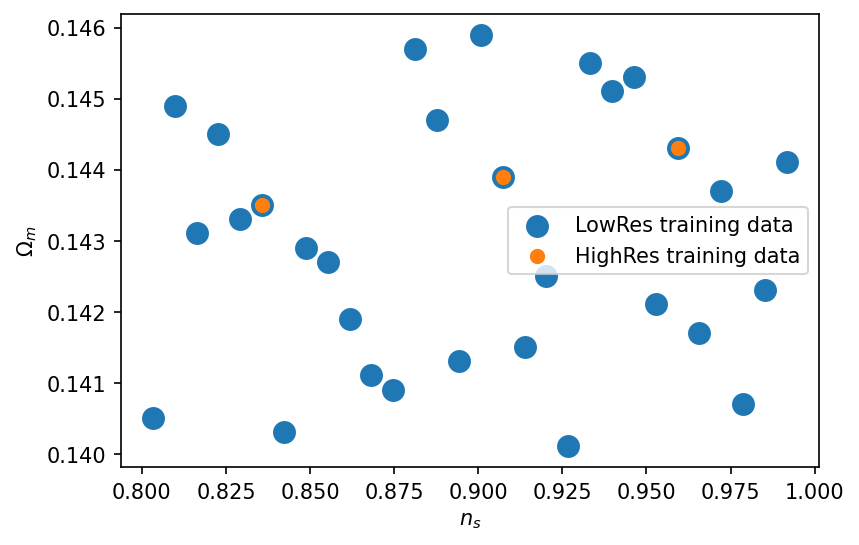

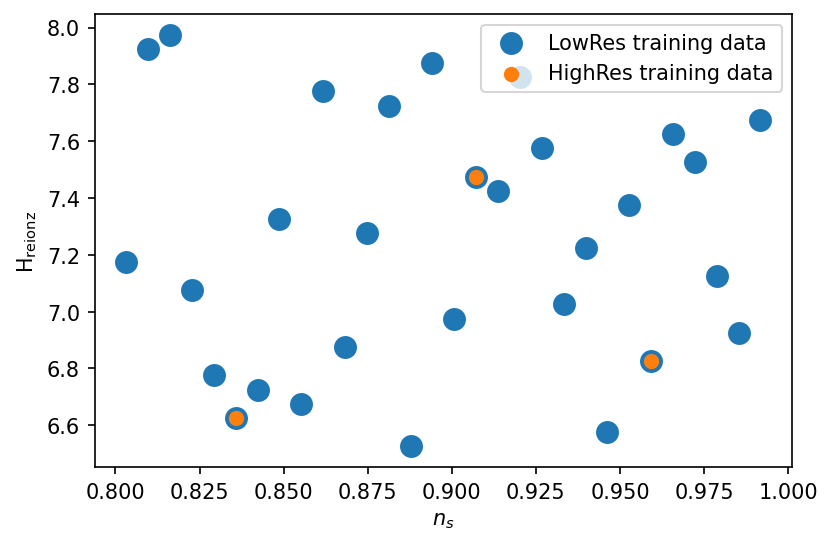

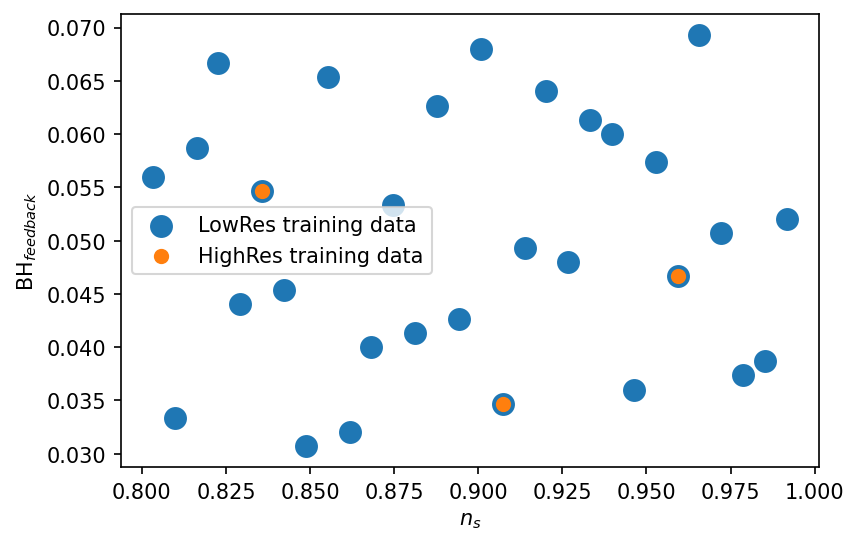

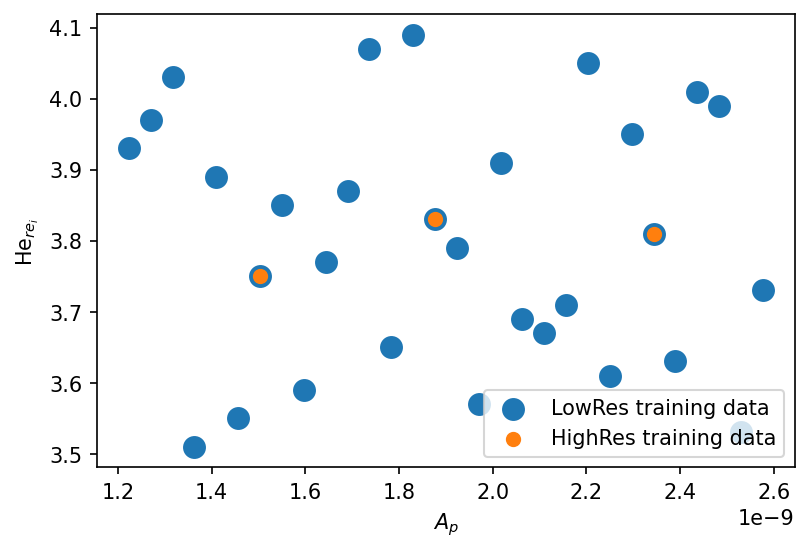

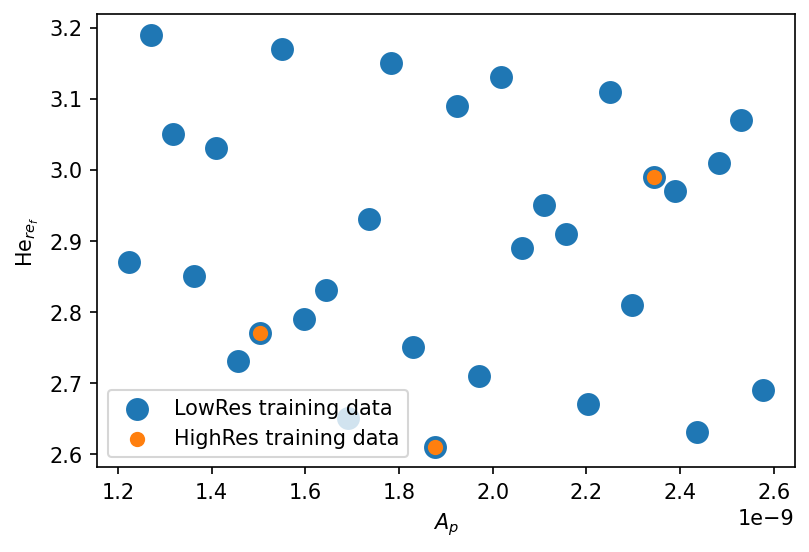

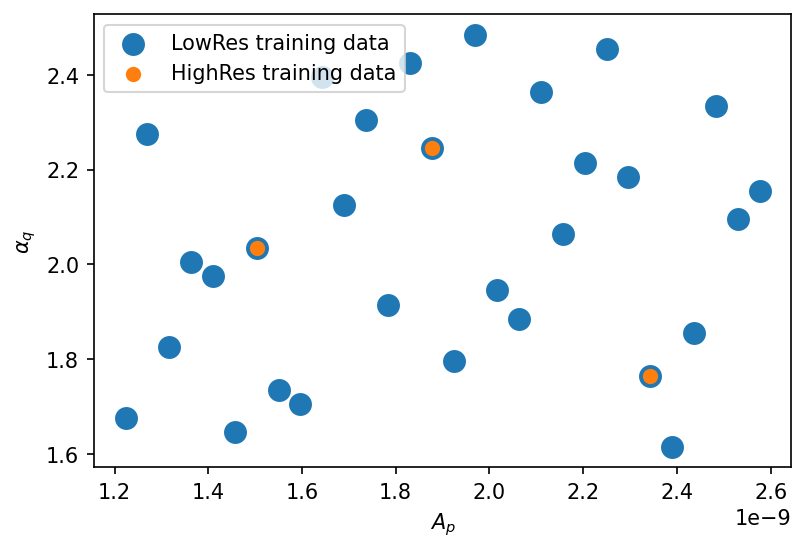

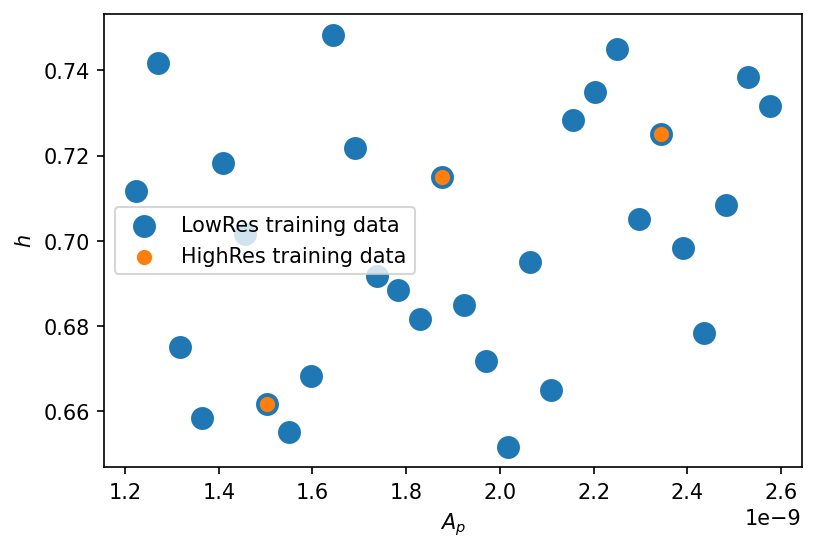

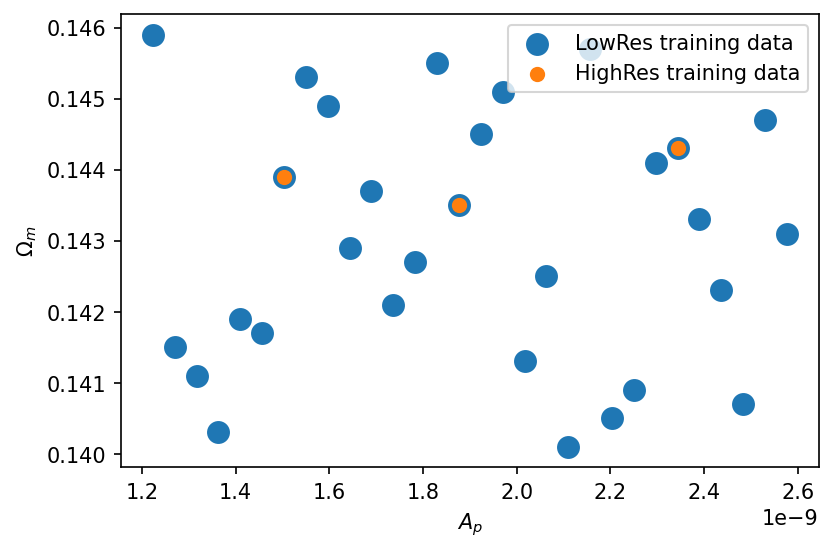

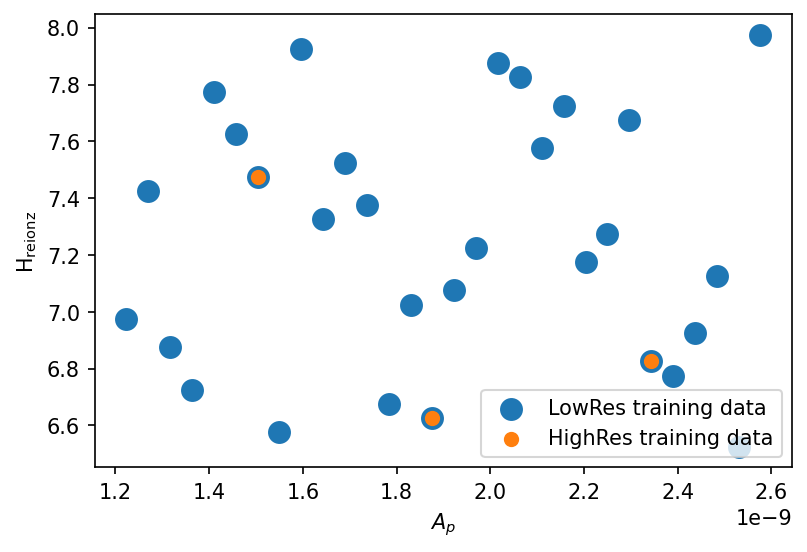

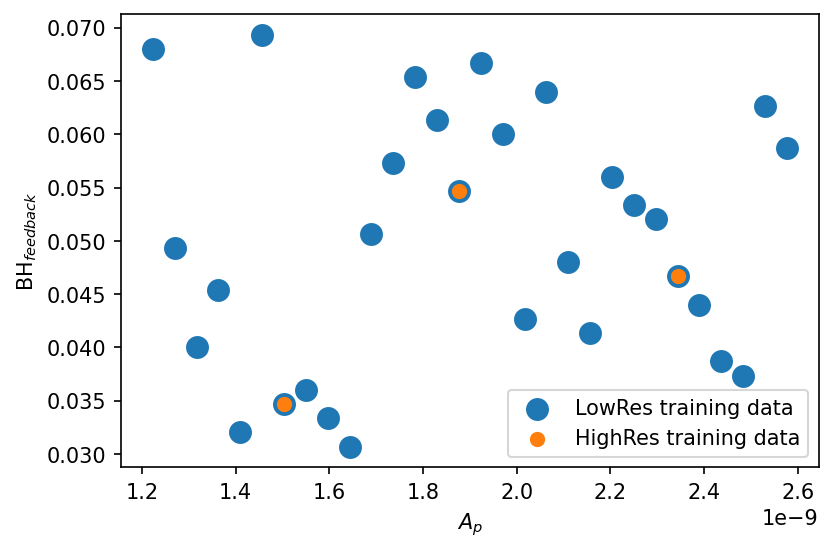

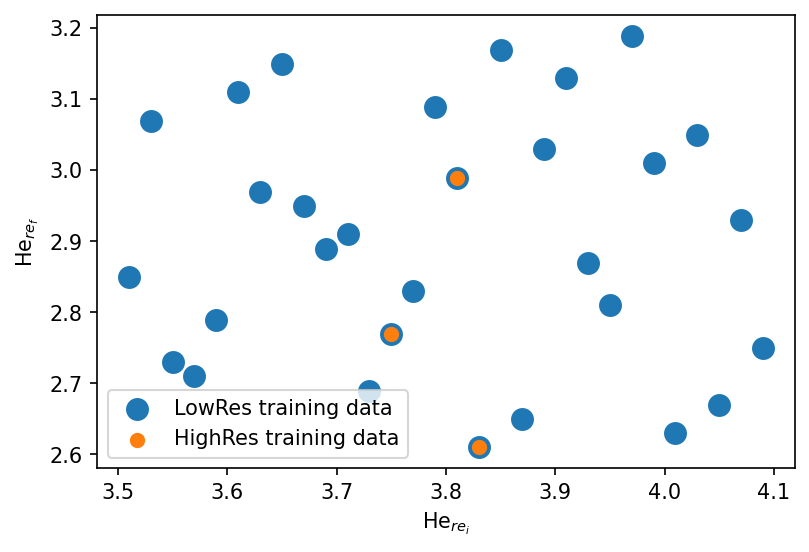

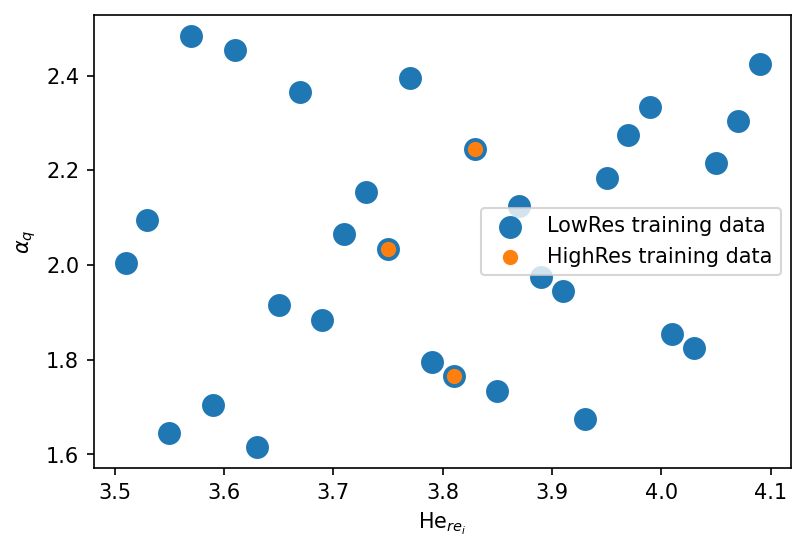

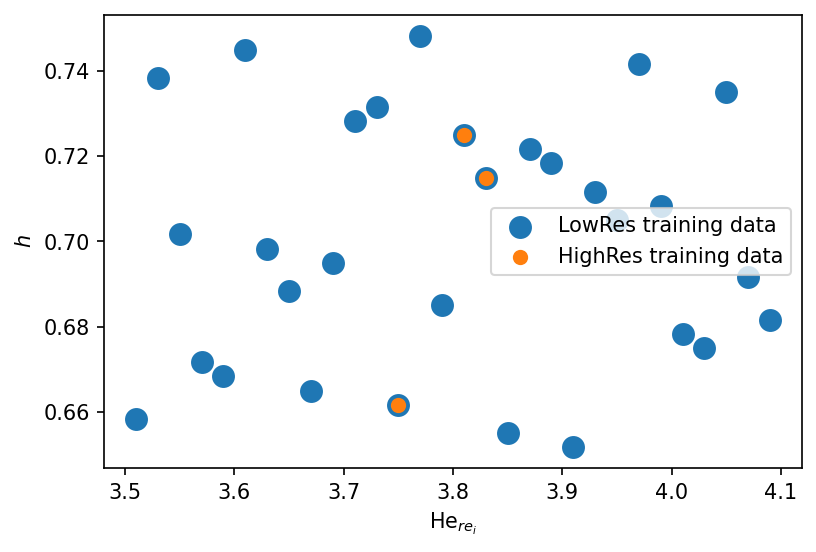

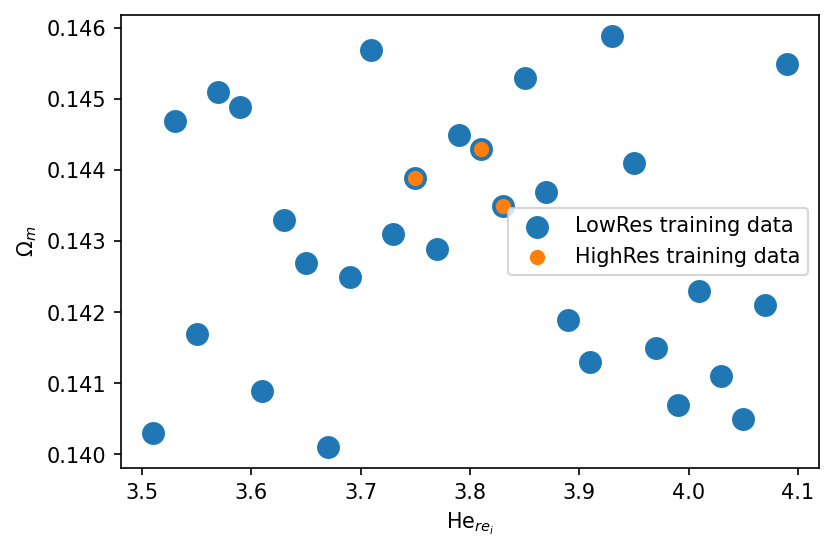

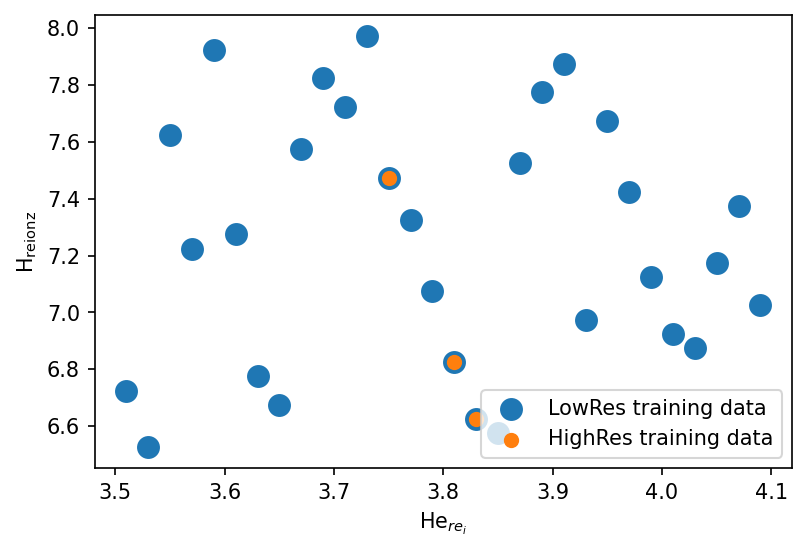

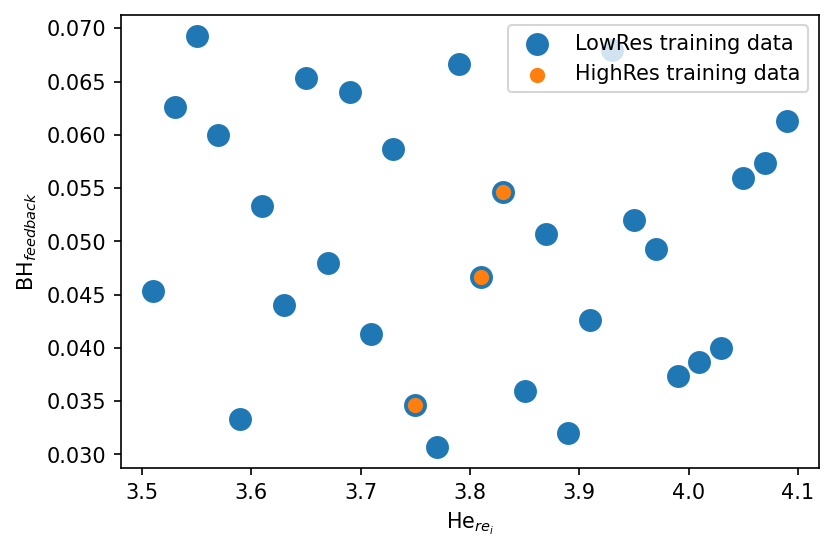

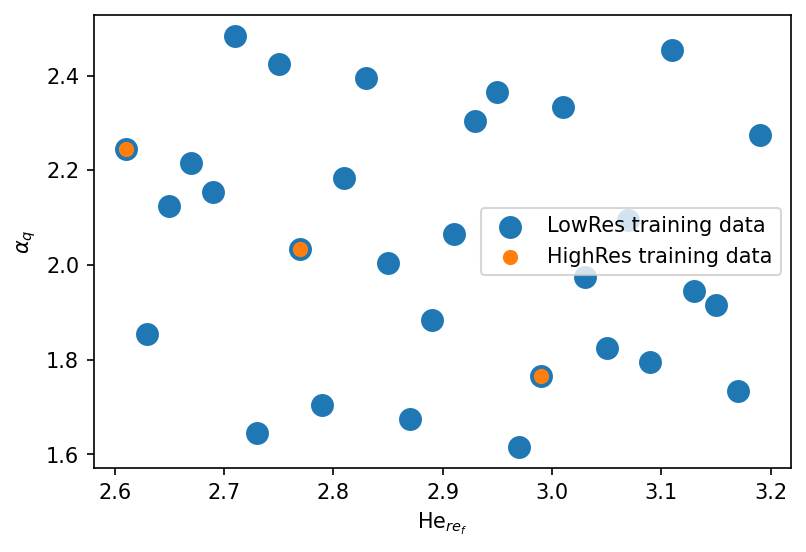

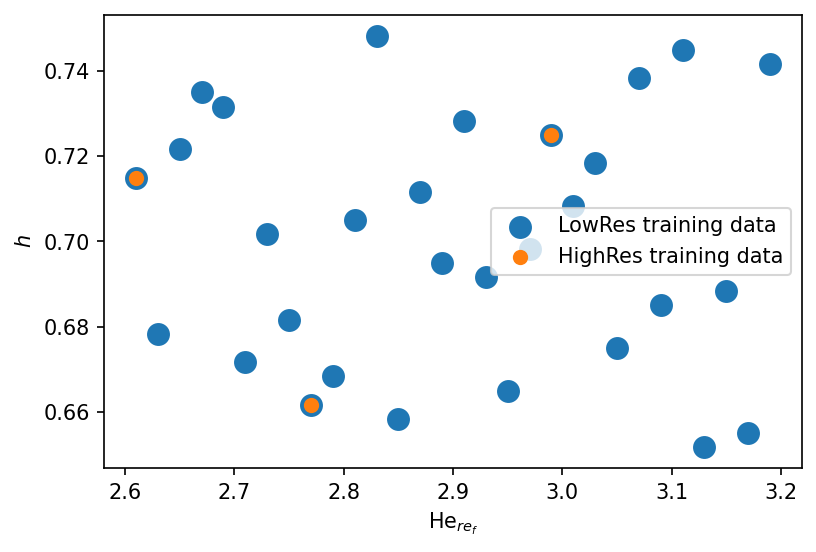

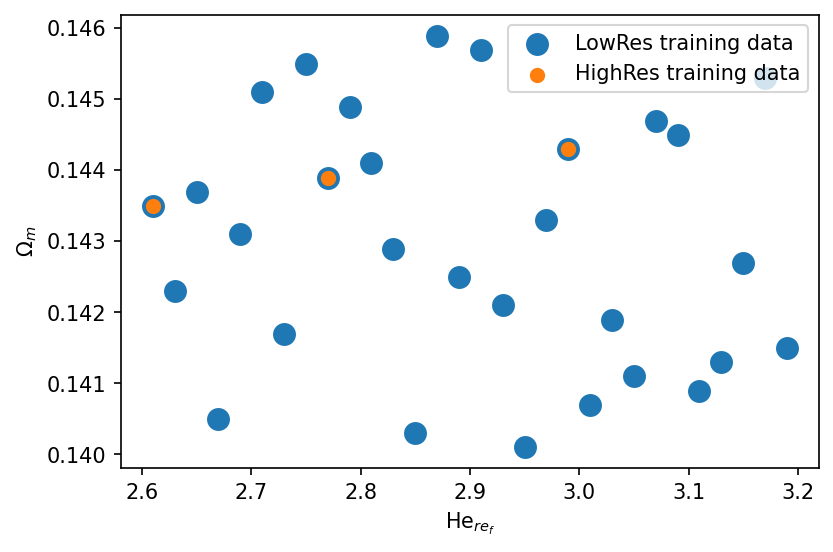

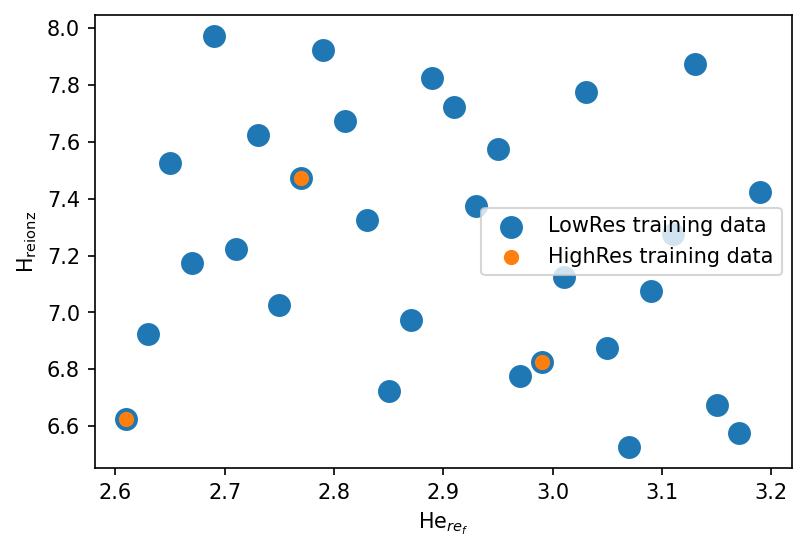

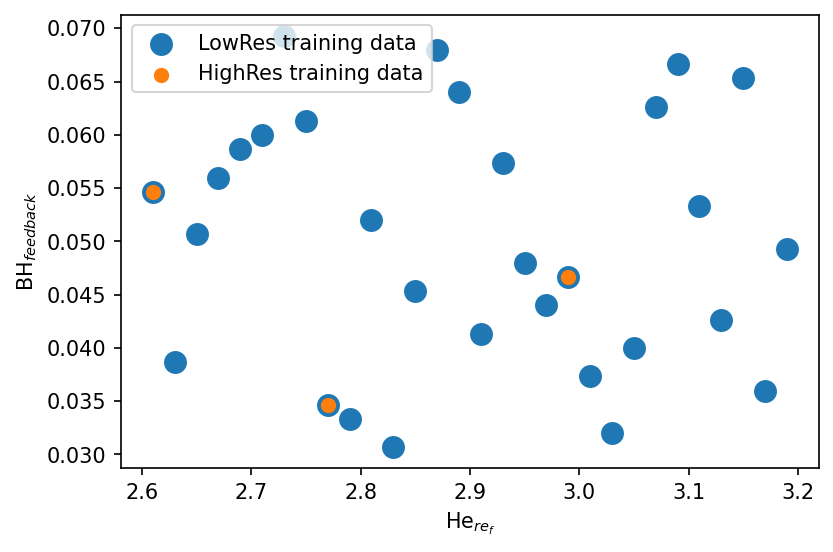

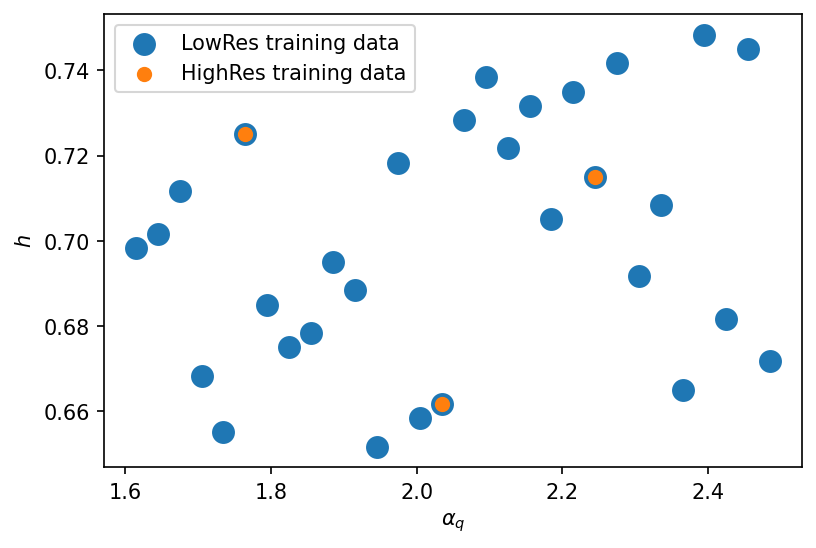

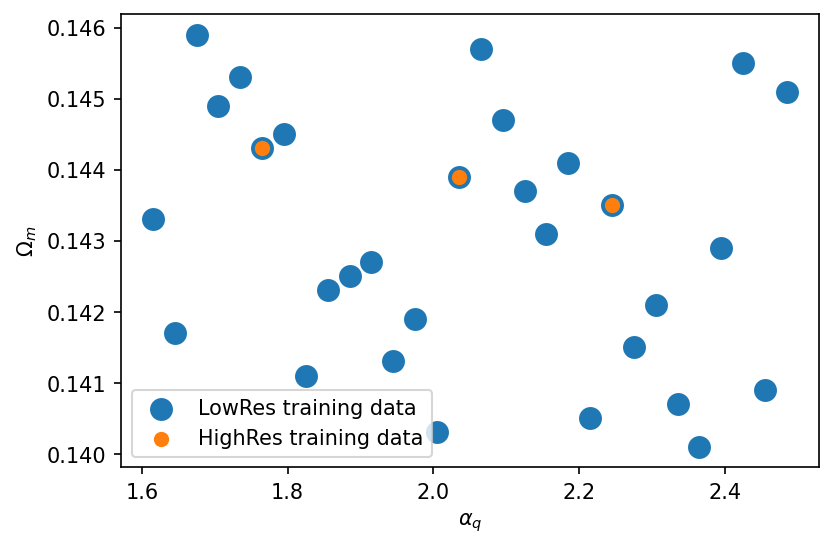

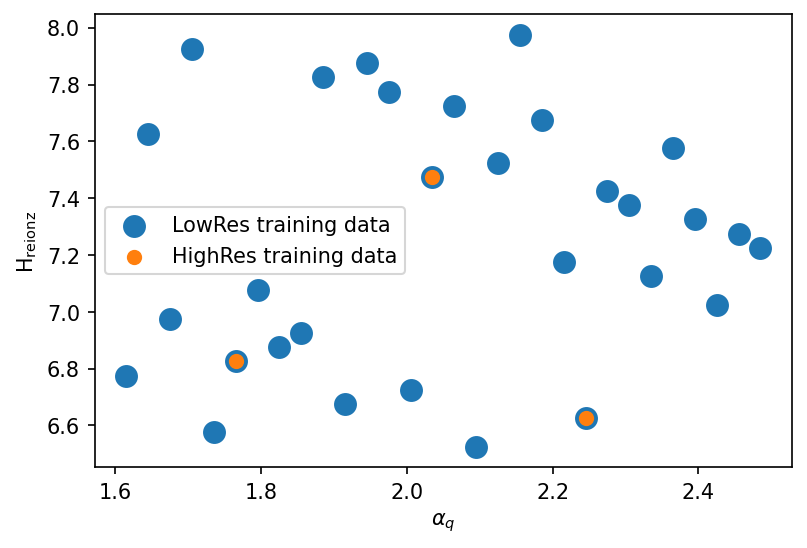

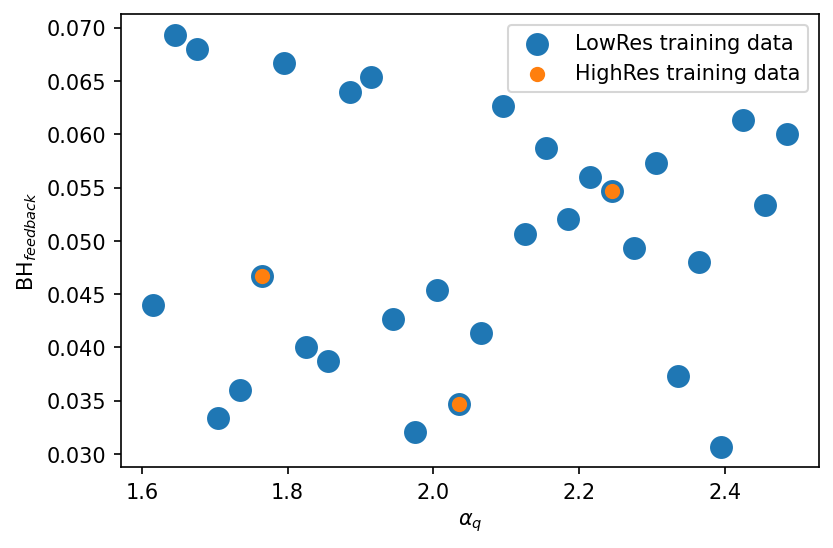

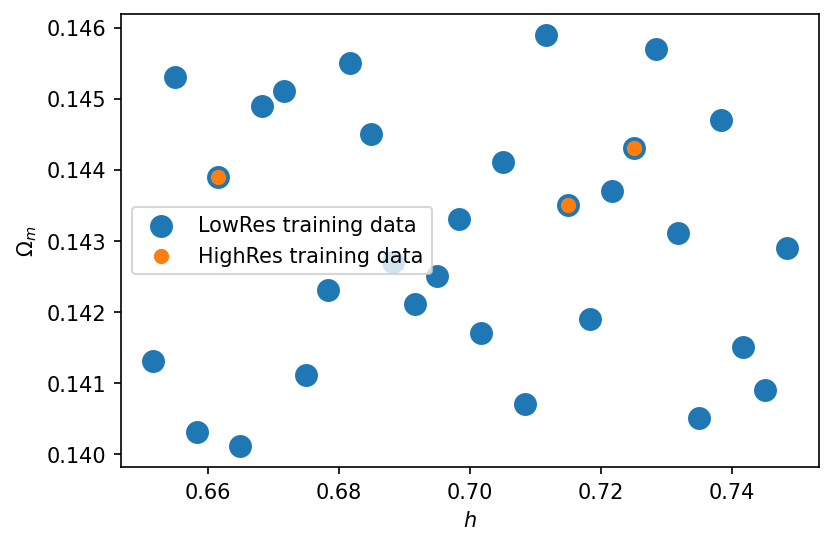

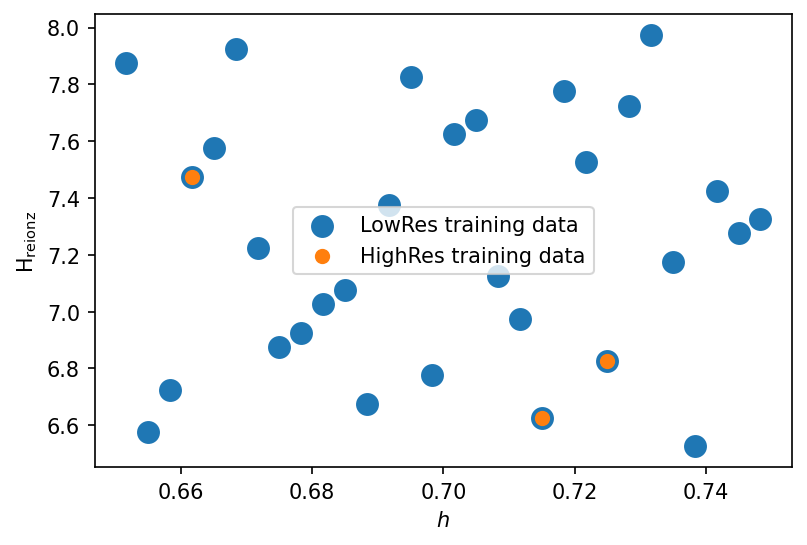

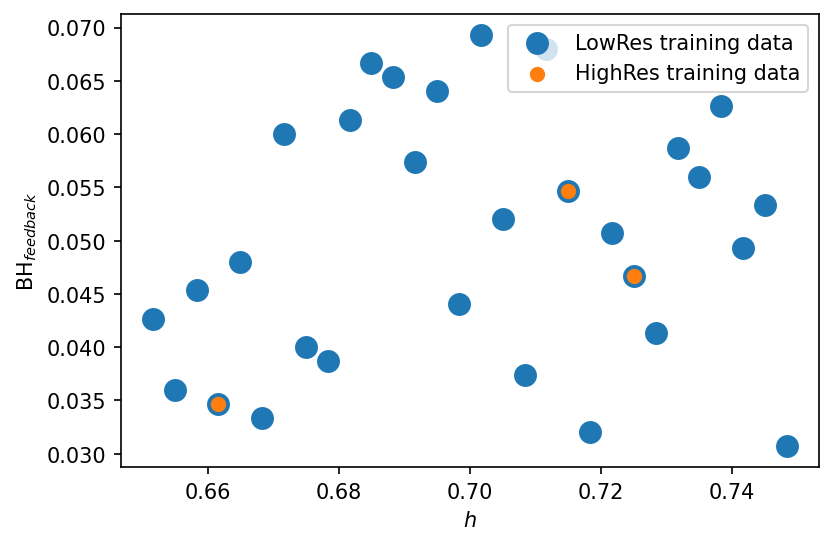

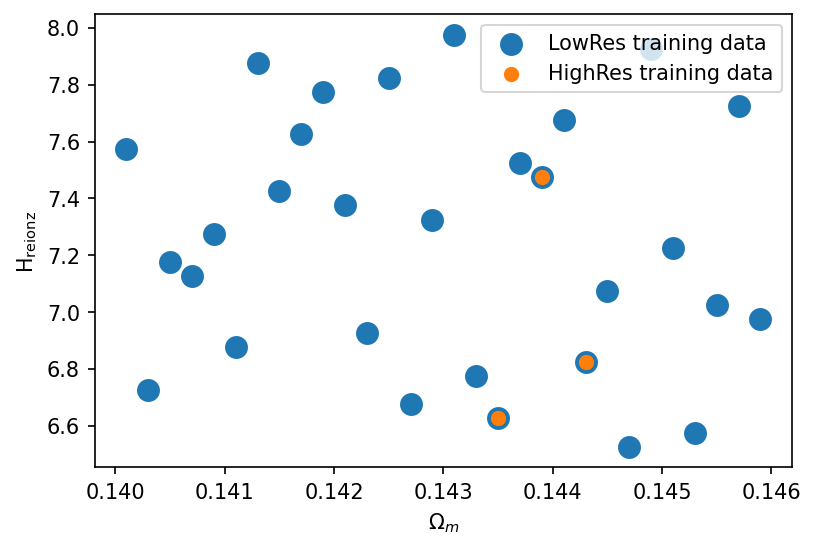

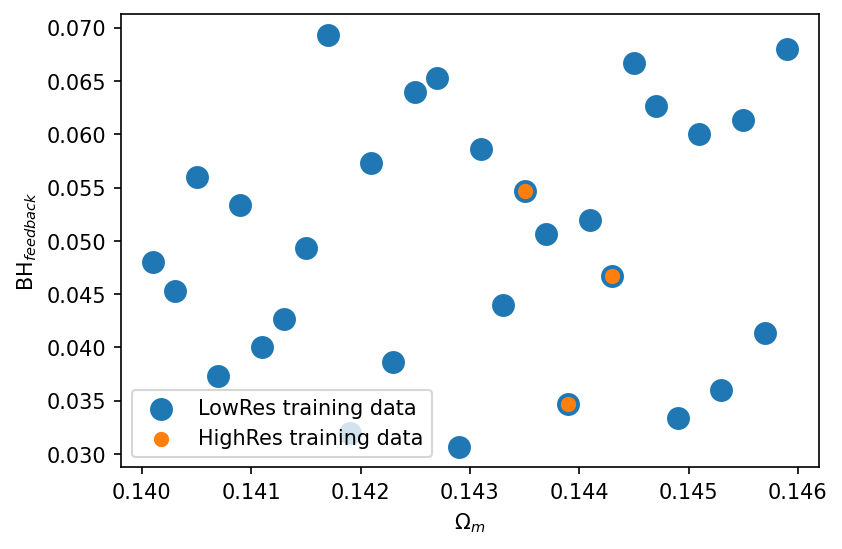

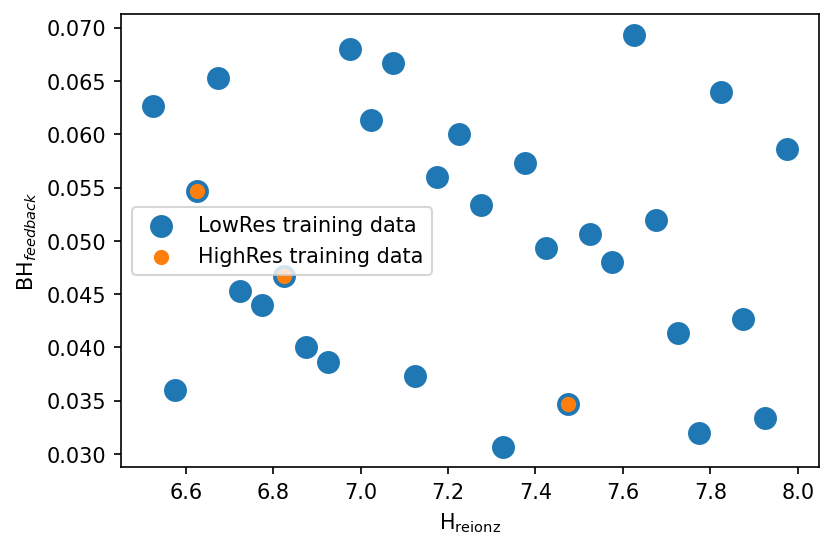

In [11]:
i = 17

print("z = {:.3g}".format(zout[i]))

plot_parameters([X_train, X_train[all_z_next_selected_index[i]]])

## Validate the choices are good enough across different redshifts

In [12]:
# examining if the z1's selected index also has a low loss at z2
all_loss_index = []
all_loss_combinations = []

for i,z in enumerate(zout):
    
    all_loss = []
    all_index = []

    for selected_index in all_z_selected_index:

        # find the loss of the selected indices (across different redshifts)
        ii = np.where(np.all(all_combinations == selected_index, axis=1))[0][0]
        assert np.all(all_combinations[ii] == selected_index)

        # i : this redshift
        # ii : the index of the selected index from all redshifts
        loss = all_z_loss[i][ii]

        all_loss.append(loss)
        all_index.append(ii)

    all_loss_combinations.append(all_loss)
    all_loss_index.append(all_index)
    
all_loss_combinations = np.array(all_loss_combinations)
all_loss_index = np.array(all_loss_index)

Text(0, 0.5, 'MSE at z = 5.4')

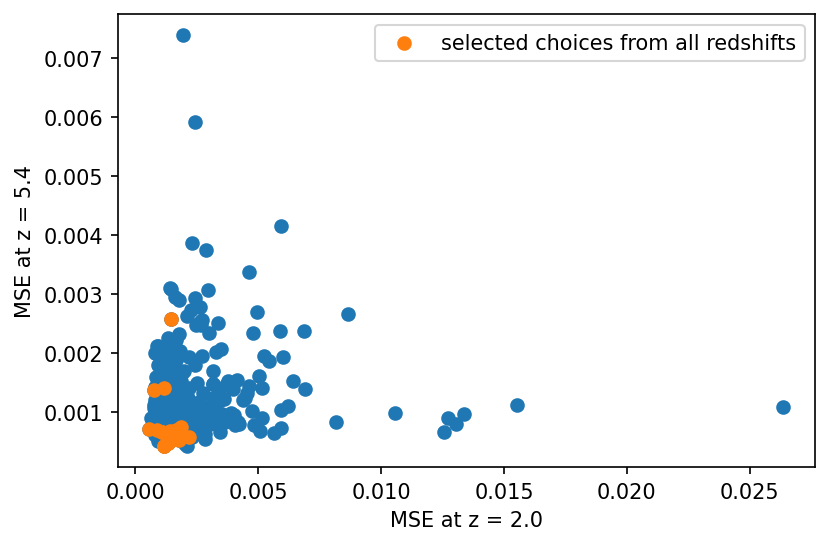

In [13]:
# dims want to be plotted
dim1 = 17
dim2 = 0

# plot two dimensions
plt.scatter(all_z_loss[dim1], all_z_loss[dim2])

# plot the selected ones
plt.scatter(
    np.array(all_z_loss)[dim1][all_loss_index[dim1]],
    np.array(all_z_loss)[dim2][all_loss_index[dim2]],
    label="selected choices from all redshifts"
)
plt.legend()
plt.xlabel("MSE at z = {}".format(zout[dim1]))
plt.ylabel("MSE at z = {}".format(zout[dim2]))